# Kilonova surrogate modelling with $\texttt{jax}$ and $\texttt{flax}$

**Abstract:** Building and training KN surrogate models with jax and flax. 

See the new tutorial notebook in the main NMMA repository to get a sense of these individual steps.

In [1]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from nmma.em.training import SVDTrainingModel
import nmma as nmma

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import jax
import jaxlib
jax.devices() # check if CUDA is present

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

## Preprocessing data

Get the filenames of the lightcurves

In [3]:
lcs_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2022" # for remote SSH Potsdam
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

There are 7700 lightcurves for this model.


Parse the data and interpolate NaNs

In [4]:
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans

data = read_photometry_files(full_filenames)
data = interpolate_nans(data)

Install wrapt_timeout_decorator if you want timeout simulations.


In [5]:
import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}

model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]
training_data, parameters = model_function(data)

Clumsy but quick way to fetch time grid and names of filters

In [6]:
key = list(training_data.keys())[0]
example = training_data[key]
t = example["t"]
keys = list(example.keys())
filts = [k for k in keys if k not in parameters + ["t"]]
print(filts)

['bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli', 'sdssu', 'ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white', 'atlasc', 'atlaso', '2massj', '2massh', '2massks', 'ztfg', 'ztfr', 'ztfi']


## Getting the SVD model

In [7]:
svd_ncoeff = 10
training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="flax",
        start_training=False # don't train, just prep the data
    )

The grid will be interpolated to sample_time with interp1d


Do the SVD projection

In [8]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter bessellux...
Normalizing mag filter bessellb...
Normalizing mag filter bessellv...
Normalizing mag filter bessellr...
Normalizing mag filter besselli...
Normalizing mag filter sdssu...
Normalizing mag filter ps1__g...
Normalizing mag filter ps1__r...
Normalizing mag filter ps1__i...
Normalizing mag filter ps1__z...
Normalizing mag filter ps1__y...
Normalizing mag filter uvot__b...
Normalizing mag filter uvot__u...
Normalizing mag filter uvot__uvm2...
Normalizing mag filter uvot__uvw1...
Normalizing mag filter uvot__uvw2...
Normalizing mag filter uvot__v...
Normalizing mag filter uvot__white...
Normalizing mag filter atlasc...
Normalizing mag filter atlaso...
Normalizing mag filter 2massj...
Normalizing mag filter 2massh...
Normalizing mag filter 2massks...
Normalizing mag filter ztfg...
Normalizing mag filter ztfr...
Normalizing mag filter ztfi...


## Training a neural network using JAX

In [9]:
from sklearn.model_selection import train_test_split

### Prepare the data

Let us train on the data of the first filter for simplicity for now:

In [10]:
X = training_model.svd_model[filts[0]]['param_array_postprocess']
print(f"Features have shape {X.shape}")

y = training_model.svd_model[filts[0]]['cAmat'].T
_, output_ndim = y.shape
print(f"Labels have shape {y.shape}")

Features have shape (7700, 6)
Labels have shape (7700, 10)


In [11]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

### Neural network architecture

Import the relevant jax and flax libraries:

In [12]:
import jax
import jax.numpy as jnp

from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses

# from clu import metrics
import optax

### Do the training

In [13]:
training_model.interpolation_type

'flax'

In [14]:
# Make sure interpolation type is JAX
training_model.train_model()

Computing NN (using flax) for filter bessellux...
Train loss at step 1: 3.410353183746338
Valid loss at step 1: 3.3974075317382812
Learning rate: 0.01
---
Train loss at step 101: 0.06252222508192062
Valid loss at step 101: 0.057176776230335236
Learning rate: 0.01
---
Train loss at step 201: 0.056650735437870026
Valid loss at step 201: 0.04767140373587608
Learning rate: 0.01
---
Train loss at step 301: 0.04376309737563133
Valid loss at step 301: 0.033974457532167435
Learning rate: 0.01
---
Train loss at step 401: 0.037084225565195084
Valid loss at step 401: 0.027186207473278046
Learning rate: 0.01
---
Train loss at step 501: 0.03501679375767708
Valid loss at step 501: 0.024133823812007904
Learning rate: 0.01
---
Train loss at step 601: 0.034856557846069336
Valid loss at step 601: 0.02366957999765873
Learning rate: 0.01
---
Train loss at step 701: 0.033811304718256
Valid loss at step 701: 0.021489938721060753
Learning rate: 0.01
---
Train loss at step 801: 0.032800350338220596
Valid loss

## Get the lightcurve

Get an example, and fetch its lightcurves and parameter values

In [37]:
idx = 0

# Original lightcurve
first_key = list(training_data.keys())[idx]
raw_lightcurves = training_data[first_key]["data"]
print(np.shape(raw_lightcurves))

# Lightcurve from surrogate model
key = list(training_data.keys())[idx]
example_parameters = [training_data[key][param] for param in parameters]
example_parameters = jnp.array(example_parameters)
# print(example_parameters)
_, _, mAB = nmma.em.utils.calc_lc(t, 
                                example_parameters, 
                                svd_mag_model=training_model.svd_model, 
                                interpolation_type="flax",
                                filters=filts)

(100, 26)


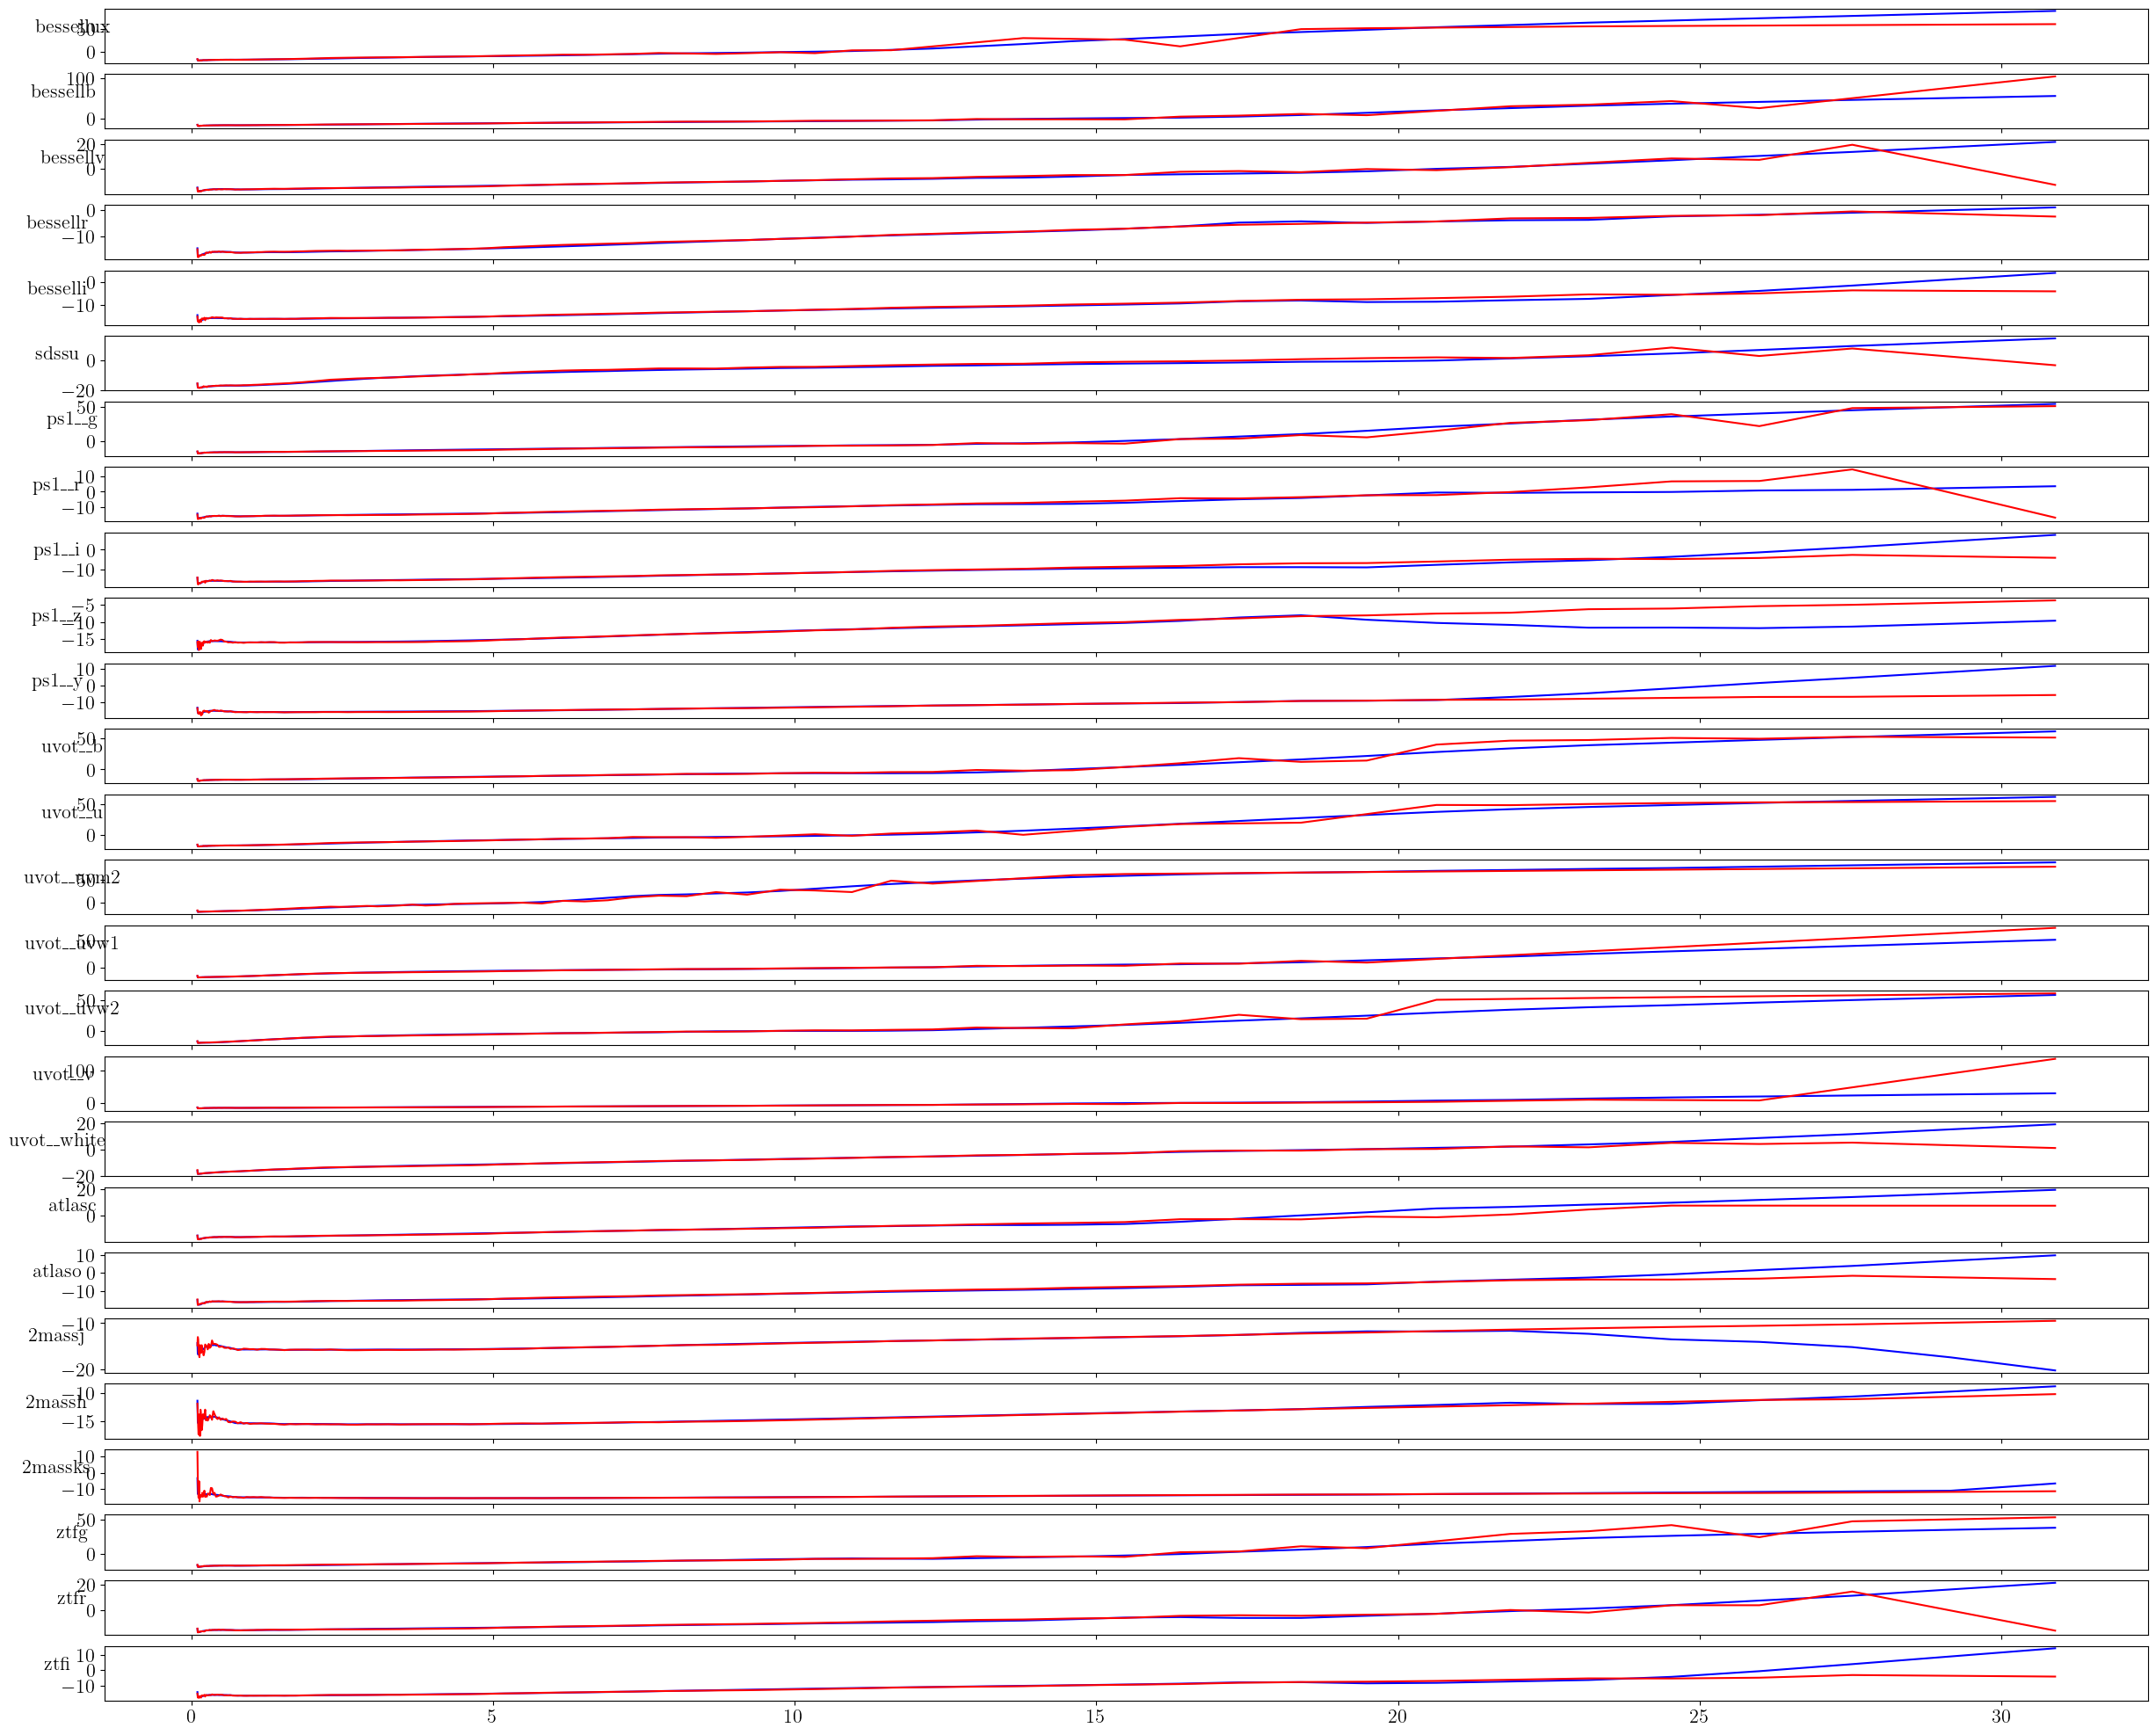

In [38]:
nrow = len(filts)
plt.subplots(nrow, 1, figsize=(30, 25), sharex = True)

for i, filt in enumerate(filts):
    plt.subplot(nrow, 1, i+1)
    # Plot the surrogate output
    plt.plot(t, mAB[filt], color="blue")
    # Also plot the raw data (also processed, interpolated etc)
    plt.plot(t, raw_lightcurves[:, i], color = "red")
    plt.ylabel(filt, rotation=0)
    plt.grid()
plt.show()

## Benchmarking surrogate model

In [39]:
def mse(x: np.array, y: np.array, mean=False):
    sq = (x - y) ** 2
    return jnp.mean(sq)

In [40]:
def se(x: np.array, y: np.array):
    return (x - y) ** 2    

In [41]:
original_lcs = dict()
# Initialize this dict for every filter
for f in filts:
    original_lcs[f] = np.zeros((len(full_filenames), 100))

In [43]:
for i, name in enumerate(filenames):
    # Get the original lc of this file
    lc = training_data[name[:-4]]["data"]
    # Save separate to every filter
    for j, f in enumerate(filts):
        original_lcs[f][i, :] = lc[:, j]

In [44]:
original_lcs[filts[0]].shape

(7700, 100)

Compute the surrogate lightcurves. Since this is quite computationally intensive, we use jit and vmap.

In [56]:
# Input data is same for every filter, doesnt matter which filter we pick
# NOTE make sure to convert from postprocessed data back to regular input data!
param_postpr = training_model.svd_model[filts[0]]['param_array_postprocess']
param_mins = training_model.svd_model[filts[0]]['param_mins']
param_maxs = training_model.svd_model[filts[0]]['param_maxs']

X = param_mins + (param_maxs - param_mins) * param_postpr
X = jnp.array(X) # turn to jax array

In [57]:
# Create lambda function for it with input params as batch
my_calc_lc = lambda x: nmma.em.utils.calc_lc_flax(t, x, svd_mag_model=training_model.svd_model, filters=filts)

In [58]:
np.shape(X)

(7700, 6)

In [59]:
_, _, surrogate_lcs = jax.vmap(my_calc_lc)(X)

In [82]:
# surrogate_lcs

In [83]:
np.shape(surrogate_lcs[filts[0]])

(7700, 100)

Verify if correct

### Compute the MSE to compare the results

In [88]:
t

array([ 0.103,  0.109,  0.116,  0.122,  0.13 ,  0.137,  0.145,  0.154,
        0.163,  0.173,  0.183,  0.194,  0.206,  0.218,  0.231,  0.244,
        0.259,  0.274,  0.29 ,  0.308,  0.326,  0.345,  0.366,  0.387,
        0.41 ,  0.435,  0.461,  0.488,  0.517,  0.547,  0.58 ,  0.614,
        0.651,  0.689,  0.73 ,  0.773,  0.819,  0.868,  0.919,  0.974,
        1.032,  1.093,  1.158,  1.226,  1.299,  1.376,  1.458,  1.544,
        1.636,  1.733,  1.836,  1.944,  2.06 ,  2.182,  2.311,  2.448,
        2.594,  2.747,  2.91 ,  3.083,  3.266,  3.459,  3.665,  3.882,
        4.112,  4.356,  4.614,  4.888,  5.178,  5.485,  5.81 ,  6.155,
        6.52 ,  6.906,  7.316,  7.75 ,  8.21 ,  8.696,  9.212,  9.759,
       10.337, 10.95 , 11.6  , 12.288, 13.016, 13.788, 14.606, 15.472,
       16.39 , 17.362, 18.392, 19.482, 20.638, 21.862, 23.158, 24.532,
       25.987, 27.528, 29.16 , 30.89 ])

In [96]:
def get_time_indices(t, t_min, t_max):
    tmin_index = np.where(t > t_min)[0][0]
    tmax_index = np.where(t < t_max)[0][-1]
    
    return tmin_index, tmax_index

In [112]:
mse_dict = dict()

for f in filts:
    # Get arrays for MSE
    a = original_lcs[f]
    b = surrogate_lcs[f]
    # Limit time window to a relevant window
    tmin = 0.1
    tmax = 15
    tmin_index, tmax_index = get_time_indices(t, tmin, tmax)
    # Slice the arrays
    a = a[:, tmin_index:tmax_index]
    b = b[:, tmin_index:tmax_index]
    # Finally, compute MSE for this filter
    mse_values = jax.vmap(mse)(a, b)
    mse_dict[f] = mse_values

Verify if correct:

In [113]:
# nrow = len(filts)
# plt.subplots(nrow, 1, figsize=(30, 25), sharex = True)

# my_index = 0

# for i, filt in enumerate(mAB):
#     plt.subplot(nrow, 1, i+1)
#     # Plot the surrogate output
#     plt.plot(t, surrogate_lcs[filt][my_index], color="blue")
#     plt.plot(t, original_lcs[filt][my_index], color="red")
#     plt.ylabel(filt, rotation=0)
#     plt.grid()
# plt.show()

In [115]:
x_list = []
for f in filts:
    mse_values = mse_dict[f]
    x = np.mean(mse_values, axis = None)
    x_list.append(x)
results_dict = {"filters": filts,
                "MSE": x_list}
print(f"Time for MSE computation was constrained in the interval [{tmin}, {tmax}]")
results_df = pd.DataFrame.from_dict(results_dict)
results_df

Time for MSE computation was constrained in the interval [0.1, 15]


,filters,MSE
0,bessellux,7.6472945
1,bessellb,2.7984574
2,bessellv,0.55307376
3,bessellr,0.12705162
4,besselli,0.1942188
5,sdssu,0.40275022
6,ps1__g,2.7578504
7,ps1__r,0.46039474
8,ps1__i,0.21413445
9,ps1__z,0.31947327


# Extra: other approaches?

(7700, 100)
(26, 100)


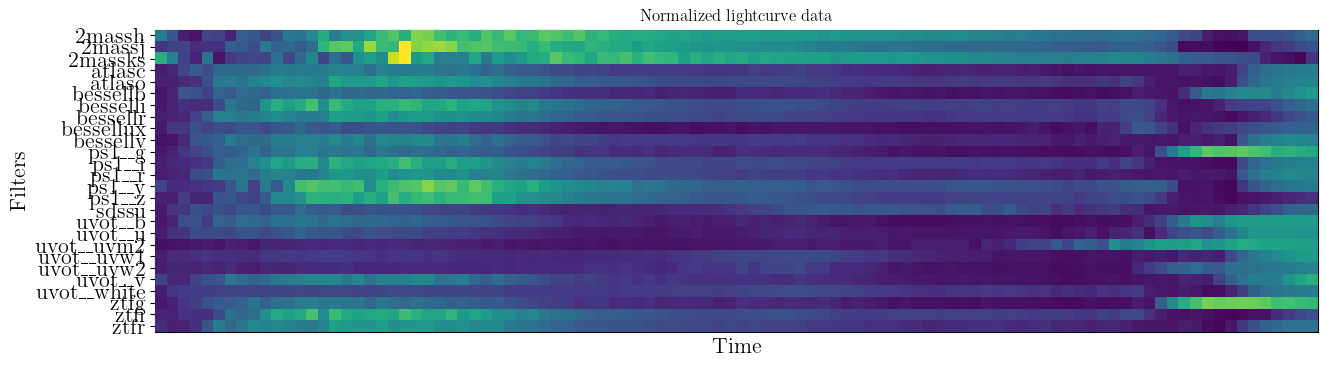

In [ ]:
# Get the data
print(training_model.svd_model[filts[0]]['data_postprocess'].shape)
example_data = np.stack([training_model.svd_model[f]['data_postprocess'][0] for f in training_model.filters])
print(example_data.shape)

# Plot the data
no_ticks = False

plt.figure(figsize = (15, 15))
plt.imshow(example_data, zorder = 10)
# Labels
plt.xlabel("Time")
plt.ylabel("Filters")
# cbar = plt.colorbar()
# cbar.set_label("Normalized LC values")
plt.title("Normalized lightcurve data")
plt.xticks([])
plt.yticks([i for i in range(len(filts))], filts)
plt.show()

In [ ]:
training_model.svd_model[filts[0]]['cAmat'].T[0]

array([-4.62778572, -0.36531729,  0.25260386, -0.06618868, -0.33647734,
       -0.22141482,  0.00837703,  0.02129562,  0.01703494, -0.02540689])

Can also do the same idea with the SVD embedding. However, not sure how informative this is going to be...

In [ ]:
# # Get the data
# example_data = np.stack([training_model.svd_model[f]['cAmat'].T[0] for f in training_model.filters])
# print(example_data.shape)

# # Plot the data
# no_ticks = False

# plt.figure(figsize = (15, 12))
# plt.imshow(example_data, zorder = 10)
# # Labels
# plt.xlabel("Time")
# plt.ylabel("Filters")
# # cbar = plt.colorbar()
# # cbar.set_label("Normalized LC values")
# plt.title("Embeddings")
# plt.xticks([])
# plt.yticks([i for i in range(len(filts))], filts)
# plt.show()